In [1]:
# load libraries
import nibabel as nib
import pandas as pd
import numpy as np

from nilearn.connectome import ConnectivityMeasure
from nilearn.maskers import NiftiLabelsMasker
from nilearn import datasets
from pathlib import Path

In [2]:
def correct_mean_var(tseries):
    
    '''
    Correct time series to zero mean and unit variance. Adapted from: 
    https://github.com/SIMEXP/niak/blob/master/commands/statistics/niak_correct_mean_var.m,
    but for a 1D array with the default 'mean_var' only.
    ------------------------------------- 
    TSERIES_N = CORRECT_MEAN_VAR(TSERIES)
    
    INPUT
    TSERIES: (1D array) time series.
    
    OUTPUT
    TSERIES_N: (1D array) same as data after mean/variance correction.
    '''
    
    nt = tseries.shape[0]
    tseries = tseries.reshape(nt,-1)
    
    mean_ts = np.mean(tseries,0)
    std_ts = tseries.std()
    
    tseries_n = (tseries - mean_ts)/std_ts
    tseries_n = np.ravel(tseries_n)
    
    return (tseries_n)

In [62]:
def build_size_roi(mask):
    
    '''
    Extract labels and size of ROIs given a mask. Adapted from:
    https://github.com/SIMEXP/niak/blob/master/commands/SI_processing/niak_build_size_roi.m
    ------------------------------------- 
    [SIZE_ROI,LABELS_ROI] = BUILD_SIZE_ROI(MASK)
    
    INPUT
    MASK: (array) voxels belonging to no region are coded with 0, those 
    belonging to region I are coded with I (I being a positive integer).
    
    OUTPUTS
    SIZE_ROI: (vector) SIZE_ROI(I) is the number of voxels in region number I.

    LABELS_ROI: (vector) LABELS_ROI(I) is the label of region I.
    '''
    labels_roi = np.unique(mask)
    labels_roi = labels_roi[labels_roi!=0]
    
    nb_roi = len(labels_roi)
    size_roi = np.zeros([nb_roi,1])
    
    for num_r in range(nb_roi):
        size_roi[num_r] = np.count_nonzero(mask==labels_roi[num_r])
    
    return (size_roi, labels_roi)

In [4]:
def mat2lvec(mat):
    
    '''
    Convert a symmetric matrix into a vector (diagonal elements included). Adapted from:
    https://github.com/SIMEXP/niak/blob/master/commands/formats/niak_mat2lvec.m
    ------------------------------------- 
    LVEC = MAT2LVEC(MAT)
    
    INPUT
    MAT: (array) a square matrix. MAT should be symmetric. Diagonal elements 
    will be included.
    
    OUTPUTS
    LVEC: (vector) a vectorized version of mat. Low-triangular and diagonal values are kept.
    '''

    N = mat.shape[1]
    mask_l = np.tril(np.ones(N, dtype=int))
    mask_l = mask_l>0
    lvec = mat[mask_l]
    
    return (lvec)

# Intra-network average connectivity

We first get the mask of parcels

In [5]:
# Load MIST 64 atlas as mask
parcellation = datasets.fetch_atlas_basc_multiscale_2015(version='sym')['scale064']
img_mist = nib.load(parcellation)
img_mist.shape

(53, 64, 52)

Fetch a demo dataset

In [6]:
# Load a few brain development fmri datasets from nilearn
data = datasets.fetch_development_fmri(n_subjects=1, reduce_confounds=True)
imgs = data.func[0:10]
confounds = data.confounds[0:10]  # This is a preselected set of confounds

Build a group mask of fMRI brains for this mini-study. Let's start by generating brain masks from the fMRI time series. 

In [13]:
from nilearn.masking import compute_multi_epi_mask
mask_epi = compute_multi_epi_mask(imgs, lower_cutoff=0.2, upper_cutoff=0.85, connected=True, 
                       opening=2, threshold=0.5, target_affine=None, target_shape=None, 
                       exclude_zeros=False, n_jobs=1, memory=None, verbose=0)

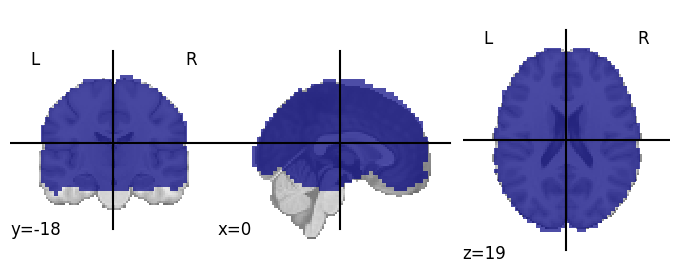

In [17]:
from nilearn.plotting import plot_roi
plot_roi(mask_epi, resampling_interpolation='nearest')

Now let's get a grey matter mask: 

In [21]:
#from nilearn.maskers import MultiNiftiMasker
#multi_masker = MultiNiftiMasker(mask_img=None, mask_strategy='epi', smoothing_fwhm=3)
#multi_masker.fit(imgs=imgs)
from nilearn.datasets import fetch_icbm152_brain_gm_mask
from nilearn.image import resample_to_img
mask_mni = fetch_icbm152_brain_gm_mask()
mask_mni = resample_to_img(source_img=mask_mni, target_img=imgs[0], interpolation='nearest')

Let's visualize it

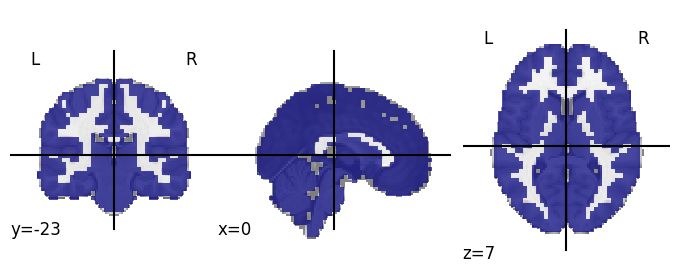

In [22]:
from nilearn.plotting import plot_roi
plot_roi(mask_mni, resampling_interpolation='nearest')

now we combine both masks into one:

In [24]:
from nilearn.image import math_img
mask_combined = math_img('img1 & img2', img1=mask_epi, img2=mask_mni)

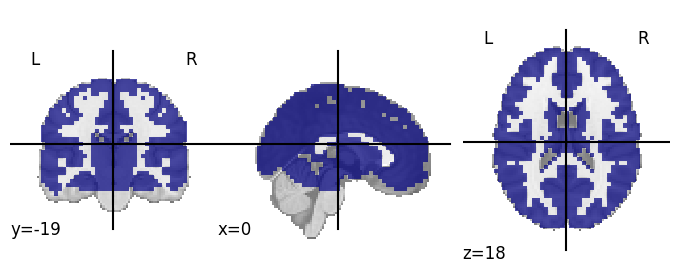

In [25]:
plot_roi(mask_combined, resampling_interpolation='nearest')

TODO: explore which MIST regions have small overlap with our mask, and possibly create a custom MIST atlas by excluding those regions 

We can now load voxel-wise data for one subject:

In [29]:
from nilearn.maskers import NiftiMasker
masker = NiftiMasker(standardize=True, mask_img=mask_combined, 
                           memory='nilearn_cache', verbose=5)
time_series_voxel = masker.fit_transform(imgs[0], confounds=confounds[0])

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x7f89049adbe0>, target_affine=None, target_shape=None, copy=False, interpolation='nearest')
_____________________________________________________resample_img - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_masker._filter_and_mask...
_filter_and_mask('/home/pbellec/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
<nibabel.nifti1.Nifti1Image object at 0x7f89049adbe0>, { 'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'low_pass': None,
  'reports': True,
  'runs': None,
  'smoothing_fwhm': None,
  'standardize': True,
  's

We have standardized the voxel time series. We convert that back into 4D so we can apply the LabelsMasker on it. 

In [31]:
img_n = masker.inverse_transform(time_series_voxel)

________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[-0.177942, ..., -1.02396 ],
       ...,
       [-0.757937, ..., -0.15459 ]]), 
<nibabel.nifti1.Nifti1Image object at 0x7f89049adbe0>)
___________________________________________________________unmask - 0.4s, 0.0min


before we do what comes next, we need to do gymnastics to ensure that we remove voxels in the mist template that are *not* in the grey matter template. No time for that here.


Time to apply the LabelsMasker.

In [34]:
# Compute time series. Here, I am setting 'standardize' to False and then using the function correct_mean_var, 
# since the time series I will be using are not standardized so wanted to check functionality
masker_mist = NiftiLabelsMasker(labels_img=img_mist, standardize=False,
                           memory='nilearn_cache', verbose=5)
time_series_mist = masker_mist.fit_transform(img_n)

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('/home/pbellec/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz')
Resampling labels
[Memory]0.7s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


Let's observe the variance of the time series. Those are directly related to the AFC of the parcels, although they need to be controlled for the size of parcels. 

In [63]:
np.var(time_series_mist, axis=0)

array([0.02342575, 0.03910933, 0.01173844, 0.01641473, 0.        ,
       0.00663648, 0.06493155, 0.01594729, 0.00153472, 0.05909162,
       0.        , 0.00157711, 0.02532564, 0.02946869, 0.        ,
       0.03666929, 0.04250325, 0.0273159 , 0.05437295, 0.07259171,
       0.03170521, 0.0025063 , 0.04952416, 0.01482298, 0.00949417,
       0.02014608, 0.04433918, 0.0296272 , 0.00059866, 0.07789224,
       0.07820752, 0.04216064, 0.14813512, 0.04979274, 0.07708937,
       0.00944081, 0.06067961, 0.06690489, 0.02113607, 0.0629136 ,
       0.01227301, 0.02499261, 0.06405503, 0.        , 0.01452952,
       0.03230438, 0.03617524, 0.        , 0.05759401, 0.0194448 ,
       0.04421128, 0.03223098, 0.04625965, 0.02522097, 0.02600274,
       0.02306564, 0.03251372, 0.03887128, 0.06622522, 0.01766225,
       0.02289135, 0.0351183 , 0.03348988, 0.03580282])

Finally we derive AFC using the same formula as in NIAK:

In [39]:
# Compute AFC. The following cells are adapted from https://github.com/SIMEXP/niak/blob/master/bricks/connectome/niak_brick_connectome.m#L248-L262 
# and I have added the corresponding matlab line

# NIAK: ir = var(tseries_n,[],1)';
var_mist = time_series_mist.var(axis=0) 

In [65]:
# Get size of ROIs

# NIAK: N = niak_build_size_roi (all_mask{num_m});
size_parcels, labels = build_size_roi(img_mist.get_fdata()) 

In [66]:
# NIAK: mask_0 = (N==0)|(N==1);
mask_empty = (size_parcels==0) | (size_parcels==1)

In [82]:
np.shape((size_parcels * (size_parcels - 1)))

(64, 1)

In [78]:
var_mist = np.reshape(var_mist, [var_mist.shape[0], 1])

In [83]:
# NIAK: ir = ((N.^2).*ir-N)./(N.*(N-1));
# This is not correct because it should result in a 64x1 array, but I can't work out what it should be...
var_mist = np.reshape(var_mist, [var_mist.shape[0], 1])
afc = ((size_parcels * size_parcels) * var_mist - size_parcels)/(size_parcels * (size_parcels - 1))
afc

array([[ 0.02247946],
       [ 0.03681603],
       [ 0.00898562],
       [ 0.01519137],
       [-0.00193798],
       [ 0.00530489],
       [ 0.06261128],
       [ 0.01248232],
       [ 0.00020698],
       [ 0.05655548],
       [-0.00102459],
       [ 0.00069511],
       [ 0.02393524],
       [ 0.02840451],
       [-0.00122699],
       [ 0.03440263],
       [ 0.04100011],
       [ 0.02604938],
       [ 0.05315279],
       [ 0.07130899],
       [ 0.02897762],
       [ 0.00145186],
       [ 0.04830246],
       [ 0.01376932],
       [ 0.00856932],
       [ 0.01879269],
       [ 0.04340409],
       [ 0.02860683],
       [-0.00028498],
       [ 0.07654413],
       [ 0.07680021],
       [ 0.04088352],
       [ 0.14586952],
       [ 0.04831496],
       [ 0.0761792 ],
       [ 0.008462  ],
       [ 0.0595962 ],
       [ 0.06561072],
       [ 0.01987465],
       [ 0.06192719],
       [ 0.01139503],
       [ 0.02348097],
       [ 0.0631645 ],
       [-0.00106496],
       [ 0.01386635],
       [ 0

In [84]:
# NIAK: ir(mask_0) = 0;
# throws error
afc[mask_empty] = 0

In [ ]:
# NIAK: conn(eye(size(conn))>0) = ir; % A tricky formula to add the average correlation within each network, at the voxel level, on the diagonal
# I think the below is doing what the NIAK code is, but unsure since the result of my 'ir' is incorrect
diagonal = np.diag_indices_from(conn)
conn[diagonal] = ir

In [ ]:
# Convert conn to lower vector
conn_lvec = mat2lvec(conn)

In [ ]:
# Fisher-Z transform, unsure how to handle the inf and nan values?
conn_z = np.arctanh(conn_lvec) 